In [1]:
from sklearn.preprocessing import RobustScaler #robust normlization for outliers
import sklearn.metrics as metrics #metrics librry
import seaborn as sns # for intractve graphs
from sklearn.ensemble import RandomForestClassifier #Random Forest
import matplotlib.pyplot as plt #for visualization
from xgboost.sklearn import XGBClassifier #XGBoost
from sklearn.metrics import classification_report
from xgboost import plot_importance #feature rimportance
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Model, load_model
from keras.layers import Input,Dense, BatchNormalization #layers of autoencoder
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping #callbacks
from keras import regularizers #regularization
from sklearn.ensemble import IsolationForest #Isolation Forest
from sklearn.mixture import GaussianMixture #Gaussian Mixture
from imblearn.over_sampling import SMOTE
import os

## DATASET LINK:
https://www.kaggle.com/mlg-ulb/creditcardfraud/download

In [3]:
## GET DATA

df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64
False
1081


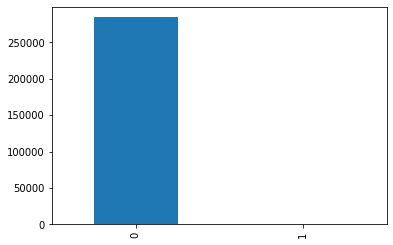

In [5]:
## Count the number of classes

print(df['Class'].value_counts())

# Check for missing values
print(df.isnull().values.any())

# Check for duplicate values
print(df.duplicated().sum())

# plot histogram of Class variable
df['Class'].value_counts().plot(kind='bar')
plt.show()




In [9]:
## SMOTE for imbalanced data

fraud_df_train = df.loc[df['Class'] == 1][:int(492*0.8)]
fraud_df_test = df.loc[df['Class'] == 1][int(492*0.8):]


#undersampling of the data. Fraude represent 10% of base now
normal_df_train_sup= df.loc[df['Class'] == 0][:int(492*0.8*9*3)]
normal_df_test= df.loc[df['Class'] == 0][int(492*0.8)*9*3:int(492*0.8*9*3)+int(284800*0.2)]
new_df_train = pd.concat([pd.DataFrame(normal_df_train_sup), fraud_df_train])

#oversampling of the data. The number of Fraud was twiced
sm = SMOTE(k_neighbors=5, random_state=0, n_jobs=8)

normal_df_train_sup, fraud_df_train = sm.fit_resample(new_df_train.drop('Class', axis=1), new_df_train['Class'])
fraud_df_train = pd.DataFrame(fraud_df_train.transpose()).rename(columns={0:"Class"})
new_df_train = pd.concat([pd.DataFrame(normal_df_train_sup), fraud_df_train ], axis=1)
new_df_train.columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount','Class']
new_df_test = pd.concat([pd.DataFrame(normal_df_test), fraud_df_test])

new_df_train.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Normal 50.0 % of the train dataset
Fraude 50.0 % of the train dataset


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Count - Train Data')

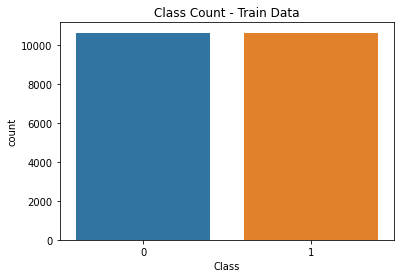

In [10]:
## Train Test Split
X_train_sup = new_df_train.drop('Class', axis=1)
y_train = new_df_train['Class']

X_test=new_df_test.drop('Class', axis=1)
y_test=new_df_test['Class']
new_df_train.head()

print('Normal', round(
        pd.Series(y_train).value_counts()[0]/len(X_train_sup)*100, 2), '% of the train dataset')
print('Fraude', round(
        pd.Series(y_train).value_counts()[1]/len(X_train_sup)*100, 2), '% of the train dataset')
sns.countplot("Class",data=new_df_train).set_title('Class Count - Train Data')

## SUPERVISED XgBoost

/usr/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


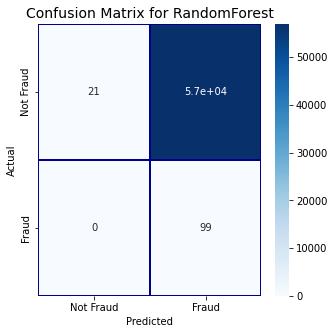

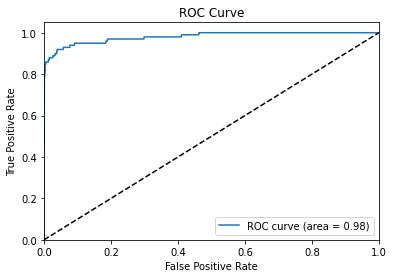

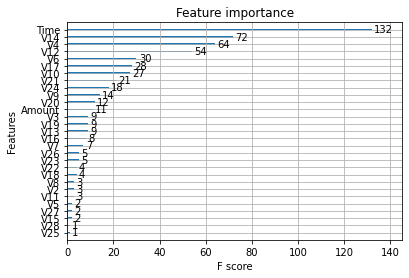

In [21]:
xgb = XGBClassifier(min_child_weight = 5, max_depth = 5, learning_rate = 0.1, n_estimators = 100, nthread = 8, subsample = 0.8, colsample_bytree = 0.8, seed = 0)
xgb.fit(X_train_sup, y_train)   #training the model

# predictions
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:,1]

# plot confusion matrix
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for RandomForest', fontsize=14)
plt.show()

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# feature importance
plot_importance(xgb)
plt.show()

# choose threshold
thresholds = np.sort(np.array(thresholds))


# save model
model_name = 'xgb_model.json'
model_path = os.path.join(os.getcwd(), model_name)
xgb.save_model(model_path)





## Semi Supervised : HMM Gaussian

<Figure size 432x288 with 0 Axes>

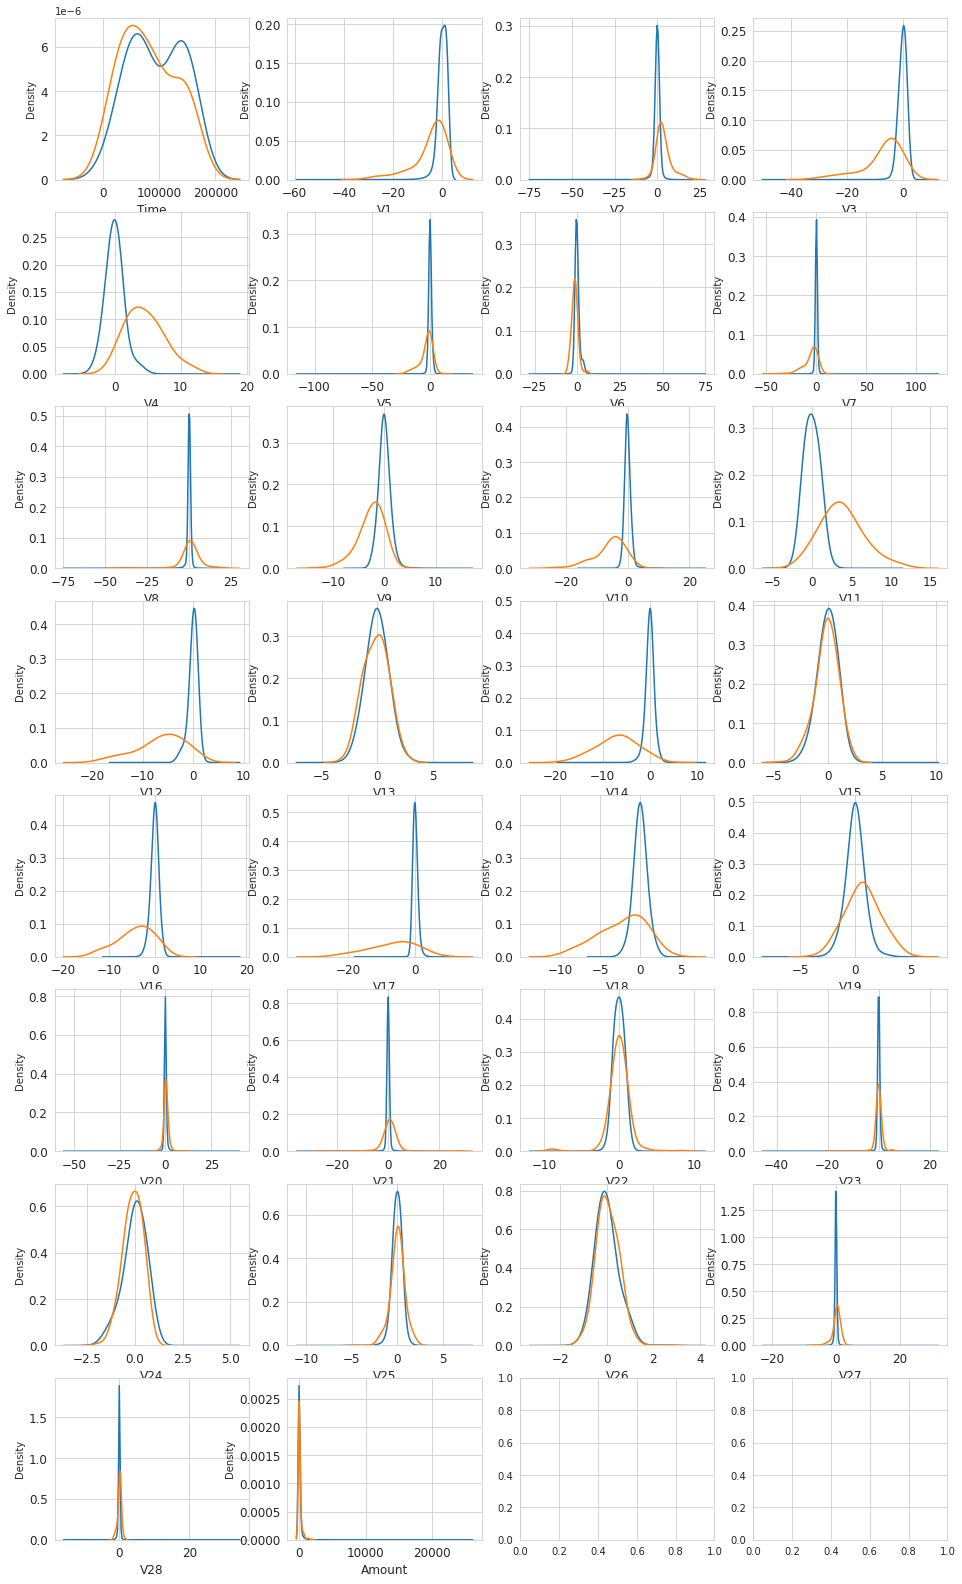

In [24]:
i=0
## suppress warnings
import warnings
warnings.filterwarnings('ignore')


t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in predictors:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [25]:
df = df.sample(frac=1, random_state=42)
fraud_df_train = df.loc[df['Class'] == 1][:int(492*0.8)]
fraud_df_test = df.loc[df['Class'] == 1][int(492*0.8):]

normal_df_test= df.loc[df['Class'] == 0][int(492*0.8)*9:int(492*0.8*9)+int(284807*0.2)]

new_df_train_semisup= df.loc[df['Class'] == 0][:int(284807*.8)]
new_df_test = pd.concat([normal_df_test, fraud_df_test])

X_train_semisup = new_df_train_semisup.drop('Class', axis=1)
X_test = new_df_test.drop('Class', axis=1)
y_test = new_df_test['Class']

The recall score is": 0.788
The precision score is": 0.363
The f2 score is": 0.638
The Kappa score is": 0.496
                  precision    recall  f1-score   support

class 0 (Normal)       1.00      1.00      1.00     56966
 class 1 (Fraud)       0.36      0.79      0.50        99

        accuracy                           1.00     57065
       macro avg       0.68      0.89      0.75     57065
    weighted avg       1.00      1.00      1.00     57065



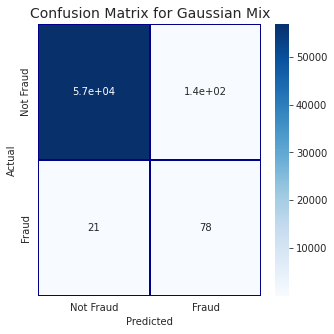

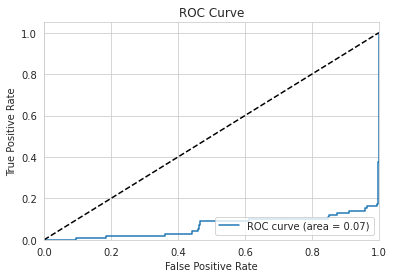

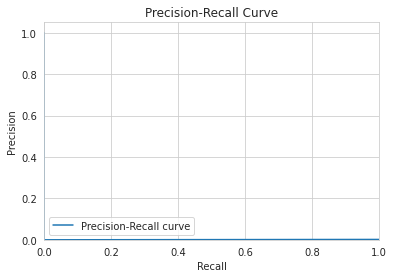

In [35]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=5)
gmm.fit(X_train_semisup)

prediction_MG = gmm.score_samples(X_test)

scores_MG = []
thresholds = np.linspace(-1000 , 100 , 200)

for threshold in thresholds:
    y_hat_MG = (prediction_MG < threshold).astype(int)
    scores_MG.append([metrics.recall_score(y_pred=y_hat_MG, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_MG, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_MG, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_MG, y2=y_test)])
    
scores_MG=np.array(scores_MG)
final_tresh = thresholds[scores_MG[:, 2].argmax()]
y_hat_MG = (prediction_MG < final_tresh).astype(int)
best_score = scores_MG[scores_MG[:, 2].argmax(),:]
recall_score = best_score[0]
precision_score = best_score[1]
fbeta_score = best_score[2]
cohen_kappa_score = best_score[3]

print('The recall score is": %.3f' % recall_score)
print('The precision score is": %.3f' % precision_score)
print('The f2 score is": %.3f' % fbeta_score)
print('The Kappa score is": %.3f' % cohen_kappa_score)
target_names = ['class 0 (Normal)', 'class 1 (Fraud)']
print(classification_report(y_test, y_hat_MG, target_names=target_names))

cm = pd.crosstab(y_test, y_hat_MG, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix for Gaussian Mix', fontsize=14)
plt.show()

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction_MG)
auc = metrics.roc_auc_score(y_test, prediction_MG)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# plot precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, prediction_MG)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



## COMBINED


In [40]:
pred_supervised = y_pred
pred_semisupervised = y_hat_MG

print(len(pred_supervised), len(pred_semisupervised))

57075 57065


In [53]:
#  combine both model predictions to give single output for each row
pred_combined = np.zeros(len(pred_semisupervised))
for i in range(len(pred_semisupervised)):
    if pred_semisupervised[i] == pred_supervised[i]:
        pred_combined[i] = pred_semisupervised[i]
    else:
        pred_combined[i] = 0

# calculate the accuracy of the combined model
accuracy_combined = metrics.accuracy_score(y_test, pred_combined)
print('The accuracy of the combined model in percentage :' ,accuracy_combined * 1e2)


The accuracy of the combined model in percentage : 99.72312275475335
